In [ ]:
EDA를 제외하고 조금 더 간소화한 버전

------------------------------------------------ 데이터 로딩 ------------------------------------------------ 

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

train = pd.read_csv('/Users/jaesolshin/내 드라이브/2024-2/Google ML Bootcamp2024/data/playground1/train.csv')

In [6]:
np.random.seed(42)

# 전체 데이터의 인덱스 생성
indices = np.arange(train.shape[0])

# 99:1 비율로 train, valid 분할
train_id, valid_id = train_test_split(indices, test_size=0.01, random_state=42)

# train에서 sample_t개, valid에서 sample_v개 샘플링
sample_t = 30000
sample_v = 1000
train_sample_id = np.random.choice(train_id, sample_t, replace=False)
valid_sample_id = np.random.choice(valid_id, sample_v, replace=False)

# train_x, train_y, valid_x, valid_y 생성
train_x = train.iloc[train_sample_id, :-1]
train_y = train.iloc[train_sample_id, -1]
valid_x = train.iloc[valid_sample_id, :-1]
valid_y = train.iloc[valid_sample_id, -1]

print("Train sample X shape:", train_x.shape)
print("Train sample Y shape:", train_y.shape)
print("Valid sample X shape:", valid_x.shape)
print("Valid sample Y shape:", valid_y.shape)

Train sample X shape: (30000, 11)
Train sample Y shape: (30000,)
Valid sample X shape: (1000, 11)
Valid sample Y shape: (1000,)


------------------------------------------------ 여기서부터 데이터 확인 및 전처리 ------------------------------------------------

In [7]:
# 범주형 변수를 팩터로 변환 (카테고리형)
train_x.iloc[:,[1,3,4,5,6,7,9]].apply(lambda x: x.astype('category'))
valid_x.iloc[:,[1,3,4,5,6,7,9]].apply(lambda x: x.astype('category'))

# 이분변수 생성: "Annual_Premium" == 2630.0 인 경우
train_x['Annual_Premium_Binary'] = (train_x['Annual_Premium'] == 2630.0).astype('category')
valid_x['Annual_Premium_Binary'] = (valid_x['Annual_Premium'] == 2630.0).astype('category')

# 로그 변환된 "Annual_Premium" 변수 생성
train_x['Annual_Premium_Log'] = np.log1p(train_x['Annual_Premium'])
valid_x['Annual_Premium_Log'] = np.log1p(valid_x['Annual_Premium'])

# 정규화
# StandardScaler, MinMaxScaler, RobustScaler 중에서 선택
from sklearn.preprocessing import StandardScaler

# 최소-최대 정규화 (Min-Max 스케일링)
scaler = StandardScaler()
train_x.iloc[:,[2,8,10]] = scaler.fit_transform(train_x.iloc[:,[2,8,10]])
valid_x.iloc[:,[2,8,10]] = scaler.fit_transform(valid_x.iloc[:,[2,8,10]])

# 예측에 필요 없는 'id'와 'Annual_Premium' 변수를 드롭
train_x = train_x.drop(columns=['id', 'Annual_Premium'])
valid_x = valid_x.drop(columns=['id', 'Annual_Premium'])

# 원-핫 인코딩 (One-Hot Encoding)
train_x = pd.get_dummies(train_x, columns=['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel', 'Annual_Premium_Binary'])
valid_x = pd.get_dummies(valid_x, columns=['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel', 'Annual_Premium_Binary'])

# train_x와 valid_x가 동일한 열을 가지도록 조정
train_x, valid_x = train_x.align(valid_x, join='left', axis=1, fill_value=0)

# XGBoost에서 발생하는 문제 해결
train_x.columns = train_x.columns.str.replace('[', '').str.replace(']', '').str.replace('<', '')
valid_x.columns = valid_x.columns.str.replace('[', '').str.replace(']', '').str.replace('<', '')


/var/folders/fx/7qldcfl92nb_g9hqp_lrssxm0000gn/T/ipykernel_78001/3830231824.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.01960119  0.57972444  2.04577294 ... -1.21951689 -0.88632405
  0.37980874]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_x.iloc[:,[2,8,10]] = scaler.fit_transform(train_x.iloc[:,[2,8,10]])
/var/folders/fx/7qldcfl92nb_g9hqp_lrssxm0000gn/T/ipykernel_78001/3830231824.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.42928188  0.57784808 -1.57577858 ...  0.01439925  0.1396101
 -0.98728757]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_x.iloc[:,[2,8,10]] = scaler.fit_transform(train_x.iloc[:,[2,8,10]])
/var/folders/fx/7qldcfl92nb_g9hqp_lrssxm0000gn/T/ipykernel_78001/3830231824.py:20: FutureWarning: Setting an item

------------------------------------------------ 이제 드디어 모델링 ------------------------------------------------

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

# 개별 모델 생성
models = [
    ('dummy', DummyClassifier(strategy="constant", constant=0)),
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('CatBoost', CatBoostClassifier(random_state=42, verbose=0)),
    ('LightGBM', LGBMClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42))
]

In [13]:
#평가를 위한 패키지 임포트
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

In [29]:
# 평가 지표 계산 함수
def evaluate_model(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # 혼동 행렬로부터 계산
    TP = conf_matrix[1, 1]
    FN = conf_matrix[1, 0]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    return {
        'Confusion Matrix': conf_matrix.tolist(),
        'Accuracy': accuracy,
        'Precision': precision,
        'Positive Recall': recall,
        'Specificity': specificity,
        'F1-Score': f1,
    }

# 결과를 저장할 리스트 초기화
results = []
probas = []

# 각 모델 학습 및 평가
for name, model in models:
    # 학습
    model.fit(train_x, train_y)
    
    # 예측
    valid_y_pred = model.predict(valid_x)
    valid_y_proba = model.predict_proba(valid_x)[:, 1]  # 양성 클래스의 확률만 저장
    
    # 평가
    metrics = evaluate_model(valid_y, valid_y_pred)
    metrics.update({
        'Model': name,
        'y_true': valid_y,
        'y_scores': valid_y_proba
    })
    
    results.append(metrics)
    probas.append(valid_y_proba)

# DataFrame 생성
results_df = pd.DataFrame(results)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3639, number of negative: 26361
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012144 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 775
[LightGBM] [Info] Number of data points in the train set: 30000, number of used features: 104
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.121300 -> initscore=-1.980177
[LightGBM] [Info] Start training from score -1.980177


In [30]:
results_df

,Confusion Matrix,Accuracy,Precision,Positive Recall,Specificity,F1-Score,Model,y_true,y_scores
0,"[[886, 0], [114, 0]]",0.886,0.000000,0.000000,1.000000,0.000000,dummy,9785583 0 4902112 0 11044333 0 8470...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[[884, 2], [114, 0]]",0.884,0.000000,0.000000,0.997743,0.000000,Logistic Regression,9785583 0 4902112 0 11044333 0 8470...,"[0.000258887850753835, 0.3919189600404307, 0.0..."
2,"[[852, 34], [97, 17]]",0.869,0.333333,0.149123,0.961625,0.206061,Random Forest,9785583 0 4902112 0 11044333 0 8470...,"[0.0, 0.42, 0.0, 0.34, 0.06, 0.19, 0.43, 0.04,..."
3,"[[876, 10], [107, 7]]",0.883,0.411765,0.061404,0.988713,0.106870,CatBoost,9785583 0 4902112 0 11044333 0 8470...,"[0.00022239308264146223, 0.40845956565156954, ..."
4,"[[881, 5], [108, 6]]",0.887,0.545455,0.052632,0.994357,0.096000,LightGBM,9785583 0 4902112 0 11044333 0 8470...,"[0.00011773120857089909, 0.3586113443550151, 0..."
5,"[[864, 22], [98, 16]]",0.880,0.421053,0.140351,0.975169,0.210526,XGBoost,9785583 0 4902112 0 11044333 0 8470...,"[0.00018470212, 0.32646984, 6.855009e-05, 0.20..."


In [31]:
# Precision과 Positive Recall 기반 가중치 계산
weights_precision = results_df['Precision'] / results_df['Precision'].sum()
weights_recall = results_df['Positive Recall'] / results_df['Positive Recall'].sum()
results_df['Weight (Precision)'] = weights_precision
results_df['Weight (Recall)'] = weights_recall

# Precision 기반 앙상블
weighted_probas_prec = np.average(probas, axis=0, weights=weights_precision)
valid_y_pred_ens_prec = (weighted_probas_prec >= 0.5).astype(int)

# Recall 기반 앙상블
weighted_probas_rec = np.average(probas, axis=0, weights=weights_recall)
valid_y_pred_ens_rec = (weighted_probas_rec >= 0.5).astype(int)

# 앙상블 모델들의 성능 평가
ensemble_results = []

for ens_name, valid_y_pred_ens, weighted_probas_ens in [("Ensemble (Precision)", valid_y_pred_ens_prec, weighted_probas_prec), 
                                                        ("Ensemble (Recall)", valid_y_pred_ens_rec, weighted_probas_rec)]:
    metrics_ens = evaluate_model(valid_y, valid_y_pred_ens)
    metrics_ens.update({
        'Model': ens_name,
        'Weight (Precision)': np.nan,
        'Weight (Recall)': np.nan,
        'y_true': valid_y,
        'y_scores': weighted_probas_ens
    })
    ensemble_results.append(metrics_ens)

# 결과 DataFrame에 앙상블 결과 추가
results_df = pd.concat([results_df, pd.DataFrame(ensemble_results)], ignore_index=True)


=== Model Results ===
      Confusion Matrix  Accuracy  Precision  Positive Recall  Specificity  F1-Score                Model  Weight (Precision)  Weight (Recall)      AUC
  [[886, 0], [114, 0]]     0.886   0.000000         0.000000     1.000000  0.000000                dummy            0.000000         0.000000 0.500000
  [[884, 2], [114, 0]]     0.884   0.000000         0.000000     0.997743  0.000000  Logistic Regression            0.000000         0.000000 0.838323
 [[852, 34], [97, 17]]     0.869   0.333333         0.149123     0.961625  0.206061        Random Forest            0.194749         0.369565 0.820042
 [[876, 10], [107, 7]]     0.883   0.411765         0.061404     0.988713  0.106870             CatBoost            0.240572         0.152174 0.843412
  [[881, 5], [108, 6]]     0.887   0.545455         0.052632     0.994357  0.096000             LightGBM            0.318680         0.130435 0.838551
 [[864, 22], [98, 16]]     0.880   0.421053         0.140351     0.9751

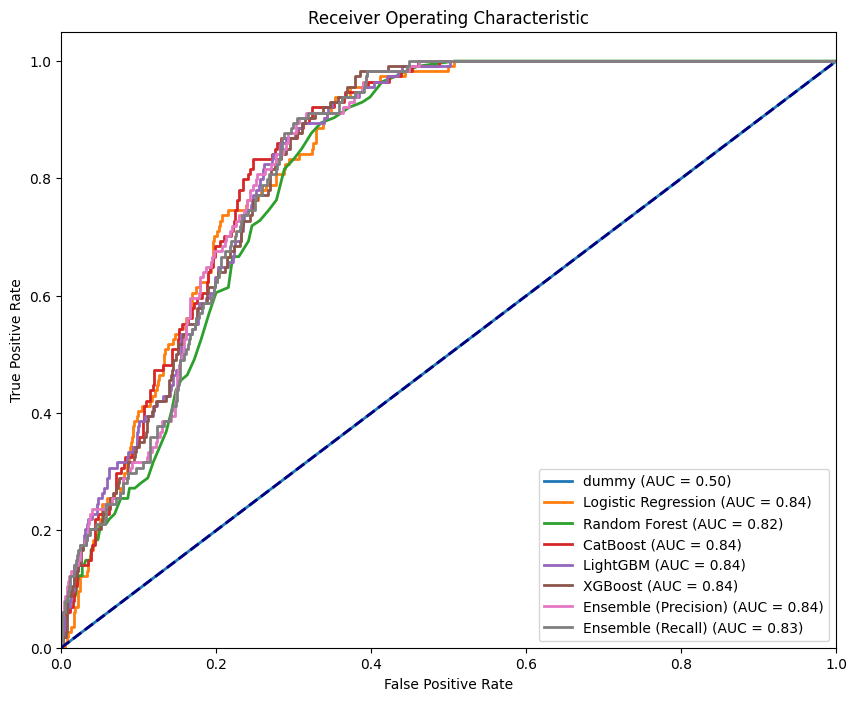

In [32]:
# AUC 값을 저장할 딕셔너리 초기화
auc_values = {}

# ROC 커브와 AUC 추가
plt.figure(figsize=(10, 8))

for index, row in results_df.iterrows():
    if pd.isna(row['y_true']).any() or pd.isna(row['y_scores']).any():
        continue  # y_true 또는 y_scores에 NaN이 있으면 건너뜀
    y_true = row['y_true']
    y_scores = row['y_scores']
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    auc_values[row['Model']] = roc_auc
    plt.plot(fpr, tpr, lw=2, label=f"{row['Model']} (AUC = {roc_auc:.2f})")

# AUC 값을 results_df에 추가
results_df['AUC'] = results_df['Model'].map(auc_values)

# 특정 열(y_true, y_scores) 제외하고 결과 출력
print("\n=== Model Results ===")
print(results_df.drop(columns=['y_true', 'y_scores']).to_string(index=False))


# ROC 커브 그리기
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [33]:
results_df

,Confusion Matrix,Accuracy,Precision,Positive Recall,Specificity,F1-Score,Model,y_true,y_scores,Weight (Precision),Weight (Recall),AUC
0,"[[886, 0], [114, 0]]",0.886,0.000000,0.000000,1.000000,0.000000,dummy,9785583 0 4902112 0 11044333 0 8470...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000,0.500000
1,"[[884, 2], [114, 0]]",0.884,0.000000,0.000000,0.997743,0.000000,Logistic Regression,9785583 0 4902112 0 11044333 0 8470...,"[0.000258887850753835, 0.3919189600404307, 0.0...",0.000000,0.000000,0.838323
2,"[[852, 34], [97, 17]]",0.869,0.333333,0.149123,0.961625,0.206061,Random Forest,9785583 0 4902112 0 11044333 0 8470...,"[0.0, 0.42, 0.0, 0.34, 0.06, 0.19, 0.43, 0.04,...",0.194749,0.369565,0.820042
3,"[[876, 10], [107, 7]]",0.883,0.411765,0.061404,0.988713,0.106870,CatBoost,9785583 0 4902112 0 11044333 0 8470...,"[0.00022239308264146223, 0.40845956565156954, ...",0.240572,0.152174,0.843412
4,"[[881, 5], [108, 6]]",0.887,0.545455,0.052632,0.994357,0.096000,LightGBM,9785583 0 4902112 0 11044333 0 8470...,"[0.00011773120857089909, 0.3586113443550151, 0...",0.318680,0.130435,0.838551
5,"[[864, 22], [98, 16]]",0.880,0.421053,0.140351,0.975169,0.210526,XGBoost,9785583 0 4902112 0 11044333 0 8470...,"[0.00018470212, 0.32646984, 6.855009e-05, 0.20...",0.245999,0.347826,0.837402
6,"[[880, 6], [104, 10]]",0.890,0.625000,0.087719,0.993228,0.153846,Ensemble (Precision),9785583 0 4902112 0 11044333 0 8470...,"[0.0001364566760795203, 0.3746520513839021, 9....",NaN,NaN,0.838541
7,"[[872, 14], [100, 14]]",0.886,0.500000,0.122807,0.984199,0.197183,Ensemble (Recall),9785583 0 4902112 0 11044333 0 8470...,"[0.00011344288567321687, 0.3777044009477998, 6...",NaN,NaN,0.834274
